In [1]:
import sys, os
sys.path.append('../')
sys.path.append('../src/')

import torch
import numpy as np
from torch.nn import Module, Parameter
from utils import preprocess
import torch.nn.functional as F

from sklearn.decomposition import PCA
from umap import UMAP

import pandas as pd 
import numpy as np 
import scipy.sparse as sp

from sklearn.metrics import adjusted_rand_score
import seaborn as sns
import matplotlib.pyplot as plt
 
import newmodel
import model
import utils

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
import importlib
importlib.reload(newmodel)

<module 'newmodel' from '/storage/hive/project/cse-vuduc/zzhang834/CFRM/src/newmodel.py'>

In [3]:
def batch_mixing_entropy(C1, C2, runs = 1):
    # construct knn graph
    k = 100
    
    C = torch.cat((C1, C2), dim = 0)
    dist = utils._pairwise_distances(C, C).numpy()
    knn_index = np.argpartition(dist, kth = k - 1, axis = 1)[:,(k-1)]
    kth_dist = np.take_along_axis(dist, knn_index[:,None], axis = 1)
    knn = ((dist - kth_dist[:, None]) <= 0)


    # select random anchors, and calculate the entropy
    entropys = []
    for run in range(runs):
        random_anchor = np.random.choice(C1.shape[0] + C2.shape[0], 100, replace=False)
        p1 = np.sum(knn[random_anchor,:C1.shape[0]], axis = 1)/100
        p2 = np.sum(knn[random_anchor,C1.shape[0]:], axis = 1)/100
        entropys.append(np.sum(p1 * np.log(p1 + 1e-6)) + np.sum(p2 * np.log(p2 + 1e-6)))
    return np.array(entropys)

In [4]:
# Read in the data: 2 batches, 3 clusters
dir = '../data/simulated/'

paths = ['2b5c_sigma0.1_1/']

for path in paths:
    
    batchsize = 0.3
    seed = 0
    losses = []
    ari_scores = []

    counts_rna = pd.read_csv(os.path.join(dir + path, 'GxC1.txt'), sep = "\t", header = None).values.T
    counts_atac = pd.read_csv(os.path.join(dir + path, 'RxC2.txt'), sep = "\t", header = None).values.T
    A = pd.read_csv(os.path.join(dir + path, 'region2gene.txt'), sep = "\t", header = None).values.T

    label_rna = pd.read_csv(os.path.join(dir + path, "cell_label1.txt"), index_col=0, sep = "\t")["pop"].values.squeeze()
    label_atac = pd.read_csv(os.path.join(dir + path, "cell_label2.txt"), index_col=0, sep = "\t")["pop"].values.squeeze()

    counts_rna = np.array(counts_rna)
    counts_atac = np.array(counts_atac)
    A = np.array(A)

    # remove one atac cluster
    counts_atac = counts_atac[np.where(label_atac != 1)[0], :]
    label_atac = label_atac[np.where(label_atac != 1)[0]]
    N1 = 5
    N2 = 4
    K = 4

    counts = {"rna":[counts_rna], "atac": [counts_atac], "gact": [A]}

    # train old model
    model1 = newmodel.cfrm_diff(counts, N1 = N1, N2 = N2, K = K, batch_size = batchsize, interval = 100, lr = 1e-3, 
                                alpha = [1000, 1000, 100, 100, 10],seed = seed, init = None, learn_gact = True).to(device)
    with torch.no_grad():
        loss, *_ = model1.batch_loss('valid')
        print('Final Loss is {:.5f}'.format(loss.item()))
        print()


    model1.train_func(T = 10000)

    # validation
    with torch.no_grad():
        loss, *_ = model1.batch_loss('valid')
        print('Final Loss is {:.5f}'.format(loss.item()))
        print()

        # z_atac = model1.softmax(torch.cat((model1.C_2.cpu().detach(),torch.zeros((model1.C_2.shape[0],1))), dim = 1)).numpy()
        z_atac = torch.cat((model1.softmax(model1.C_2).cpu().detach(),torch.zeros((model1.C_2.shape[0],1))), dim = 1).numpy()
        z_rna = model1.softmax(model1.C_1).cpu().detach().numpy()

    max_rna = np.argmax(z_rna, axis = 1)
    max_atac = np.argmax(z_atac, axis = 1)
    
    # ARI score, same as what is used in Fabian benchmark code
    ari = adjusted_rand_score(labels_pred = np.concatenate((max_rna, max_atac), axis = 0), labels_true = np.concatenate((label_rna, label_atac), axis = 0))
    print("ARI score: {:.3f}".format(ari))


Final Loss is 19.06484

Epoch 100, Validating Loss: -110.8289
	 loss 1: 27.46535
	 loss 2: 48.50919
	 loss 3: -99.99836
	 loss 4: -96.82639
	 loss 5: 10.02127
Epoch 200, Validating Loss: -112.1965
	 loss 1: 27.42773
	 loss 2: 48.48543
	 loss 3: -99.99995
	 loss 4: -98.11888
	 loss 5: 10.00912
Epoch 300, Validating Loss: -112.8373
	 loss 1: 27.41957
	 loss 2: 48.45970
	 loss 3: -99.99997
	 loss 4: -98.69444
	 loss 5: 9.97779
Epoch 400, Validating Loss: -113.0812
	 loss 1: 27.41600
	 loss 2: 48.44472
	 loss 3: -99.99997
	 loss 4: -98.87907
	 loss 5: 9.93712
Epoch 500, Validating Loss: -113.1530
	 loss 1: 27.40374
	 loss 2: 48.41789
	 loss 3: -99.99995
	 loss 4: -98.86452
	 loss 5: 9.88989
Epoch 600, Validating Loss: -113.1662
	 loss 1: 27.39420
	 loss 2: 48.36663
	 loss 3: -99.99992
	 loss 4: -98.76778
	 loss 5: 9.84072
Epoch 700, Validating Loss: -113.3043
	 loss 1: 27.38553
	 loss 2: 48.17282
	 loss 3: -99.99980
	 loss 4: -98.66127
	 loss 5: 9.79846
Epoch 800, Validating Loss: -113.847

Epoch 6200, Validating Loss: -136.7780
	 loss 1: 17.60740
	 loss 2: 34.47135
	 loss 3: -99.99977
	 loss 4: -97.89255
	 loss 5: 9.03558
Epoch 6300, Validating Loss: -136.7881
	 loss 1: 17.60710
	 loss 2: 34.46671
	 loss 3: -99.99973
	 loss 4: -97.87965
	 loss 5: 9.01748
Epoch 6400, Validating Loss: -136.8247
	 loss 1: 17.60408
	 loss 2: 34.46403
	 loss 3: -99.99974
	 loss 4: -97.90514
	 loss 5: 9.01207
Epoch 6500, Validating Loss: -136.8451
	 loss 1: 17.60355
	 loss 2: 34.46318
	 loss 3: -99.99977
	 loss 4: -97.91485
	 loss 5: 9.00283
Epoch 6600, Validating Loss: -136.8511
	 loss 1: 17.60295
	 loss 2: 34.46072
	 loss 3: -99.99973
	 loss 4: -97.90016
	 loss 5: 8.98513
Epoch 6700, Validating Loss: -136.8879
	 loss 1: 17.60276
	 loss 2: 34.45535
	 loss 3: -99.99968
	 loss 4: -97.92692
	 loss 5: 8.98057
Epoch 6800, Validating Loss: -136.8914
	 loss 1: 17.60405
	 loss 2: 34.45489
	 loss 3: -99.99968
	 loss 4: -97.91505
	 loss 5: 8.96436
Epoch 6900, Validating Loss: -136.9039
	 loss 1: 17.606

In [5]:
model1.A_r

Parameter containing:
tensor([[-0.1215, -1.6496, -2.7578, -2.9738,  6.2323],
        [-4.3763,  1.0710,  7.2472, -2.2271, -1.2184],
        [ 5.3607, -3.9005,  1.4248,  2.0897, -0.1756],
        [-3.0798,  3.1322, -0.9841,  6.9443, -2.9913]], device='cuda:0',
       requires_grad=True)

In [6]:
model1.A_g

Parameter containing:
tensor([[-0.1378, -1.8334, -3.0387, -3.2876,  6.9031],
        [-4.8362,  1.1890,  8.0192, -2.4640, -1.3548],
        [ 5.9322, -4.3171,  1.5740,  2.3119, -0.1929],
        [-3.3979,  3.4793, -1.0914,  7.6818, -3.3147],
        [ 2.6300,  3.3729, -1.9259, -0.3071, -1.0380]], device='cuda:0',
       requires_grad=True)

In [7]:
import matplotlib.pyplot as plt

In [8]:
z_rna.mean(axis = 0)

array([0.21559298, 0.20575467, 0.18004544, 0.26250756, 0.13609895],
      dtype=float32)

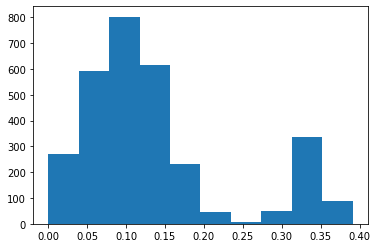

In [9]:
_ = plt.hist(z_rna[:,-1])

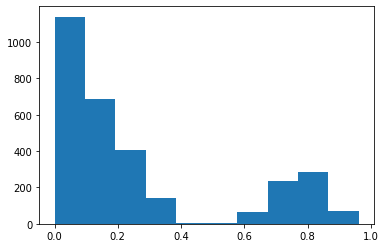

In [10]:
_ = plt.hist(z_rna[:,-2])

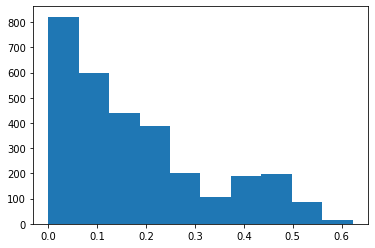

In [11]:
_ = plt.hist(z_rna[:,-3])

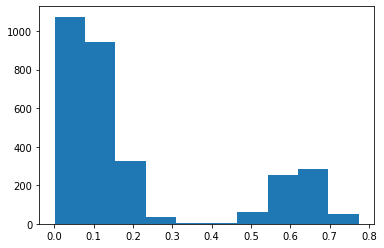

In [12]:
_ = plt.hist(z_rna[:,-4])

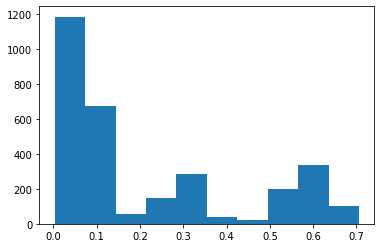

In [13]:
_ = plt.hist(z_rna[:,-5])

In [14]:
C_g = model1.softmax(model1.C_g).data.detach().cpu().numpy()
np.mean(C_g, axis = 0)

array([0.20213094, 0.20732355, 0.1927893 , 0.1909925 , 0.20676374],
      dtype=float32)

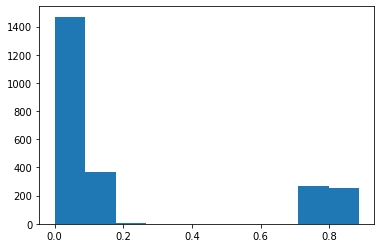

In [15]:
_ = plt.hist(z_atac[:,-2])

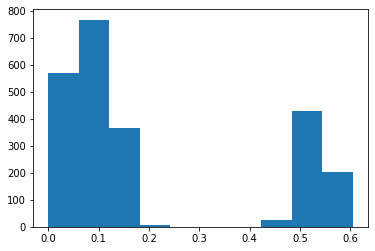

In [16]:
_ = plt.hist(z_atac[:,-3])

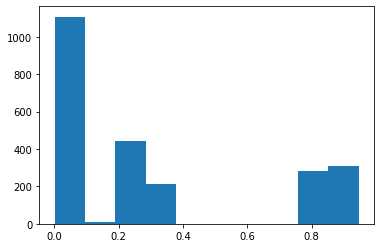

In [17]:
_ = plt.hist(z_atac[:,-4])

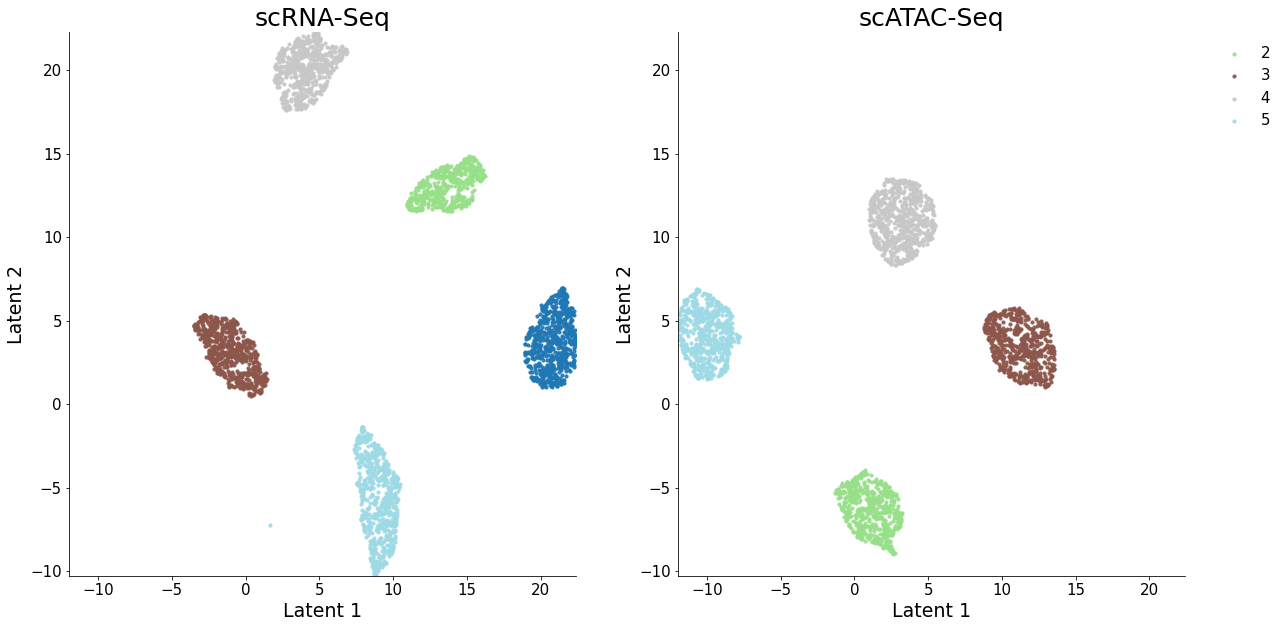

In [18]:
# plots
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 
z = umap_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))

utils.plot_latent(z[:z_rna.shape[0],:], z[z_rna.shape[0]:,:], label_rna, label_atac, mode= "separate", save = None)

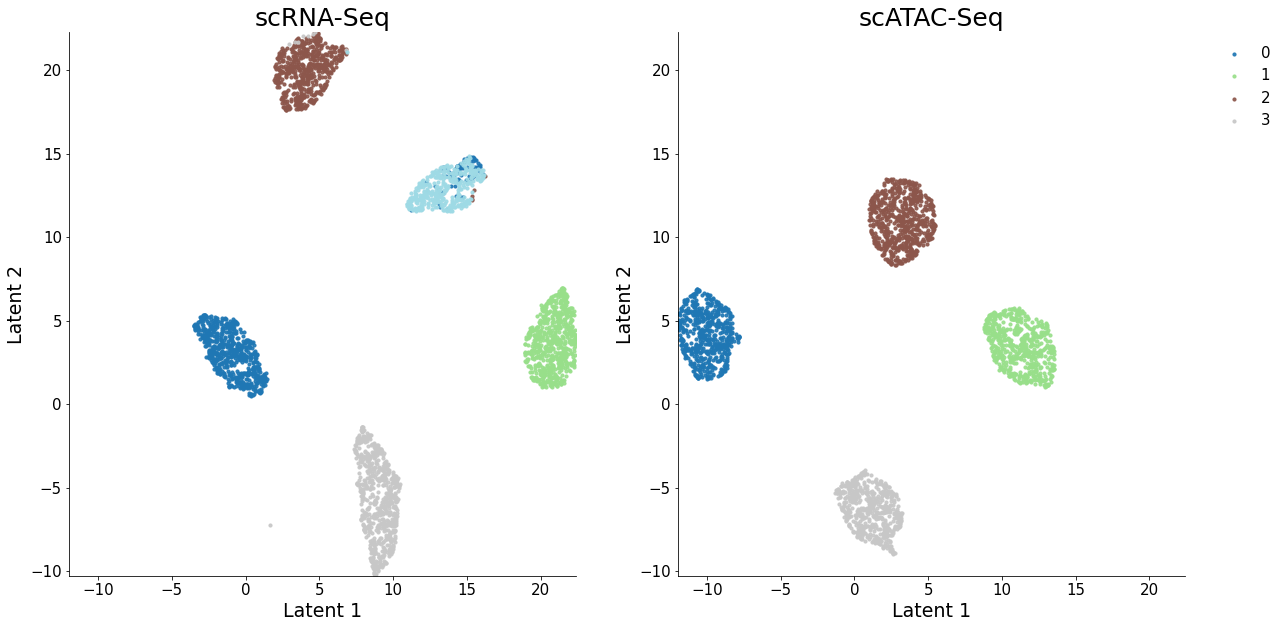

In [19]:
utils.plot_latent(z[:z_rna.shape[0],:], z[z_rna.shape[0]:,:], max_rna, max_atac, mode= "separate", save = None)

In [ ]:
C2 = torch.cat((model1.softmax(model1.C_2.cpu().detach()),torch.zeros((model1.C_2.shape[0],1))), dim = 1).numpy()
C1 = model1.softmax(model1.C_1.cpu().detach()).numpy()

import pandas as pd 
pd.DataFrame(data = C1).to_csv("C1.")